#Christian Altamirano 309878

# Métodos de Diferencias Temporales (TD)

En este notebook vamos a ver métodos de diferencias temporales en particular, vamos a ver un método de control on-policy (Sarsa) y un método off-policy (Q-Learning) para estimar la funcion de valor (y la política) óptima para un problema. 


El notebook se basa en el capítulo 6 del libro de Sutton y Barto.


****

## Ambiente

Vamos a utilizar un problema clásico de Reinforcement Learning, y para ello vamos a usar otro ambiente de OpenAi gym: MountainCar: https://gym.openai.com/envs/MountainCar-v0/ o https://gymnasium.farama.org/environments/classic_control/mountain_car/.

La descripcion del mismo es la siguiente:

Un auto esta posicionado en un carril de una dimension entre dos montañas. El objetivo es llegar a la cima de la montaña derecha pero, el motor del auto no es lo suficientemente fuerte para hacerlo en una sola pasada (no puede simplemente acelerar y llegar). Entonces, la única forma de tener éxito es ir de atrás hacia delante repetidas veces para acumular suficiente energía para subir.

![Image](https://i.ytimg.com/vi/slIJHOuTCmc/hqdefault.jpg)

Este ambiente tiene representación gráfica visual en gym, para ello vamos a hacer uso de unas funciones auxliares para poder ver resultados en video en colab.


****

## A entregar:

- Implementación de algoritmo Q-Learning
- Implementacion de algoritmo Sarsa
- Comparacion entre ambos para el ambiente dado, cuanto tarda cada uno en llegar al objetivo (en promedio). 





### Funciones auxiliares para visualizar el ambiente

In [1]:
# Dependencias necesarias.
!pip install --upgrade gymnasium > /dev/null 2>&1
!pip install --upgrade pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# Para ejecutar en CECOFI
#!pip install moviepy
#!pip install gymnasium[classic-control]

In [3]:
# Imports y funciones para ver el ambiente.
from tqdm.notebook import tqdm_notebook
import io
#import gym
import gymnasium as gym
import glob
import base64
#from gym.wrappers import Monitor
from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('./videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  """
  Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
  """
  
  #env = Monitor(env, './video', force=True)
  env = RecordVideo(env,video_folder='./videos')
  return env

### Creación del ambiente y visualizacion de un agente aleatorio.



In [4]:
# Necesitamos "envolver" el ambiente para hacer uso de las funciones definidas anteriormente.
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

# El resto del código es igual a lo que venimos acostumbrados.
observation,_ = env.reset()

while True:
    env.render()  # Queremos poder ver el ambiente. 

    action = env.action_space.sample() 
    observation, reward, done, truncated, info = env.step(action) 
        
    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


### Interacción con el ambiente

El ambiente cuenta con 3 acciones: Acelerar a la izquierda, frenar y acelerar a la derecha. Las recompensas son -1 por cada accion tomada con excepcion de llegar a la cima de la montaña. Un episodio se termina al alcanzar la cima o al luego de 200 interacciones.

Lo que podemos observar al interactuar con el es un valor real para su Velocidad (negativa al ir para la izquierda, positiva a la derecha) y un valor real para su Posicion en la línea.

Ambos valores son continuos, esto nos representa un problema, ya que queremos modelar una función de valor y una política para todos los estados posibles.

Para atacar este problema vamos a **DISCRETIZAR** el ambiente, esto es: convertir la posicion y velocidad del auto en valores discretos dentro de un rango definido.

Para ello vamos a definir algunas constantes y una función que nos permite obtener una representacion discreta de las observaciones del ambiente.


In [5]:
import numpy as np

# We will use 40 different values for Position and 40 for velocity (40x40 combinations)
NUMBER_STATES = 40

def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    env_den = (env_high - env_low) / NUMBER_STATES
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]
    
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

Una vez tenemos el ambiente discretizado, podemos crear una tabla que contenga el valor esperado para cada estado posible (donde en este caso, cada estado es una terna de: posicion, velocidad y accion a tomar). 

Esta tabla es normalmente conocida como "Q table" por su uso en Q learning (aunque tambien se usa, pero de manera distinta en Sarsa).

### Q-Learning

Vamos a comenzar implementando Q-learning para el problema actual, la implementacion corre por parte de los estudiantes.

Recordamos aquí el algoritmo:

![Image](https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png)

In [6]:
def q_learning(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table as a matrix of NumberStatesxNumberStatesxNumberActions
  Q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  episode_rewards = [] # Track the accumulated reward per episode
  episode_steps = [] # Track the number of steps taken in each episode
  wins = []              # Track the number of times we reach the goal (1 if we do, 0 otherwise)

  for ep_idx in tqdm_notebook(range(number_episodes)):

    # Reset the environment and get initial position and velocity
    observation, info = env.reset()
    position, velocity = discretization(env, observation)

    done = False
    truncated = False
    rewards = 0
    steps = 0

    while not (done or truncated):

      # Epsilon greedy policy.
      action = np.argmax(Q_table[position][velocity])
      if np.random.uniform() < epsilon:
        action = np.random.choice(env.action_space.n)
      
      # Take action on env and observe result.
      observation, R, done, truncated, _ = env.step(action)
      next_position, next_velocity = discretization(env, observation)


      # Q-Learning Update rule.
      max_action_value_next_state = np.max(Q_table[next_position][next_velocity])
      current_action_value_of_state = Q_table[position][velocity][action]
      Q_table[position][velocity][action] += alpha*(R+gamma*(max_action_value_next_state) - current_action_value_of_state)
     
      # Move the state forward.
      position, velocity = next_position, next_velocity
      rewards += R
      steps+=1
    
    # Count number of "wins" for mountain car env.
    episode_rewards.append(rewards)
    episode_steps.append(steps)
    if done:
      wins.append(1)
    else:
      wins.append(0)

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  return Q_table, episode_rewards, episode_steps, wins

In [7]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
Q_table_q_learning, rewards, steps_q_learning, wins = q_learning(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

  0%|          | 0/4000 [00:00<?, ?it/s]

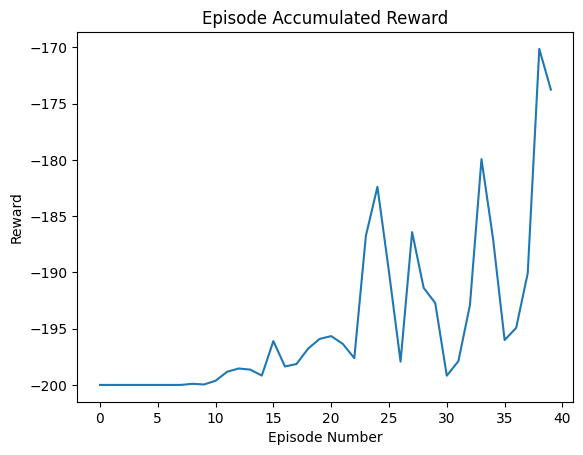

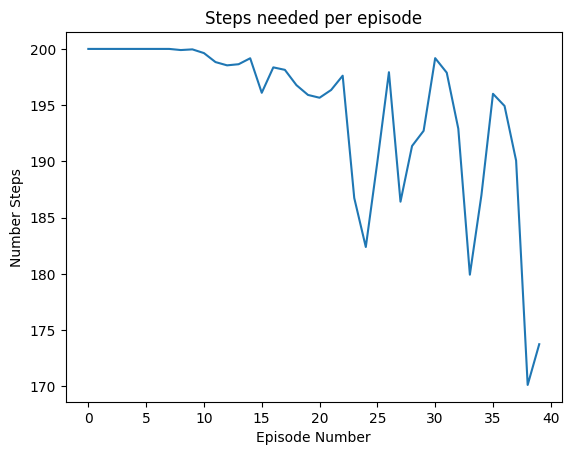

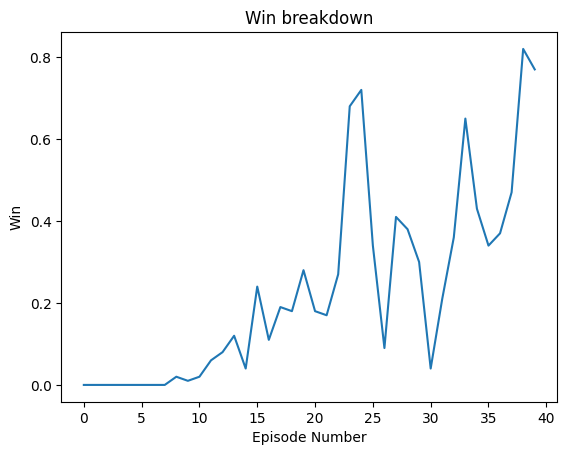

In [8]:
import matplotlib.pyplot as plt

# Average results every N timesteps for better visualization.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps_q_learning).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Plot

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

## Visualizacion del agente

Vamos a ejecutar una política completamente greedy para observar lo aprendido por el algoritmo, usando la q_table retornada por el mismo para decidir la mejor accion.


In [9]:
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

observation,_ = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(Q_table_q_learning[position][velocity])
    observation, reward, done, truncated, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


### Implementación de Sarsa


![Image](https://miro.medium.com/max/2612/1*Wim9wr-jYJtZyZ_4ZJRHNg.jpeg)

In [10]:
def sarsa(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table as a matrix of NumberStatesxNumberStatesxNumberActions
  Q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  episode_rewards = [] # Track the accumulated reward per episode
  episode_steps = [] # Track the number of steps taken in each episode
  wins = []              # Track the number of times we reach the goal (1 if we do, 0 otherwise)

  for ep_idx in tqdm_notebook(range(number_episodes)):

    # Reset the environment and get initial position and velocity
    observation, info = env.reset()
    position, velocity = discretization(env, observation)

    done = False
    truncated = False
    rewards = 0
    steps = 0

    # Epsilon greedy policy.
    action = np.argmax(Q_table[position][velocity])
    if np.random.uniform() < epsilon:
      action = np.random.choice(env.action_space.n)

    while not (done or truncated):

      # Take action on env and observe result.
      observation, R, done, truncated, _ = env.step(action)
      next_position, next_velocity = discretization(env, observation)

      # Epsilon greedy policy next action.
      next_action = np.argmax(Q_table[next_position][next_velocity])
      if np.random.uniform() < epsilon:
        next_action = np.random.choice(env.action_space.n)


      # SARSA rule.
      next_action_value_of_state = Q_table[next_position][next_velocity][next_action]
      current_action_value_of_state = Q_table[position][velocity][action]
      Q_table[position][velocity][action] += alpha*(R+gamma*(next_action_value_of_state) - current_action_value_of_state)
     
      # Move the state forward.
      position, velocity, action = next_position, next_velocity, next_action
      rewards += R
      steps+=1
    
    # Count number of "wins" for mountain car env.
    episode_rewards.append(rewards)
    episode_steps.append(steps)
    if done:
      wins.append(1)
    else:
      wins.append(0)

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  return Q_table, episode_rewards, episode_steps, wins

In [11]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
Q_table, episode_rewards, episode_steps_sarsa, wins = sarsa(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

  0%|          | 0/4000 [00:00<?, ?it/s]

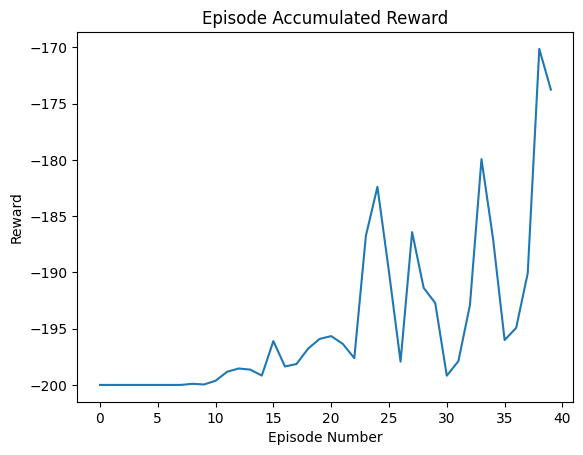

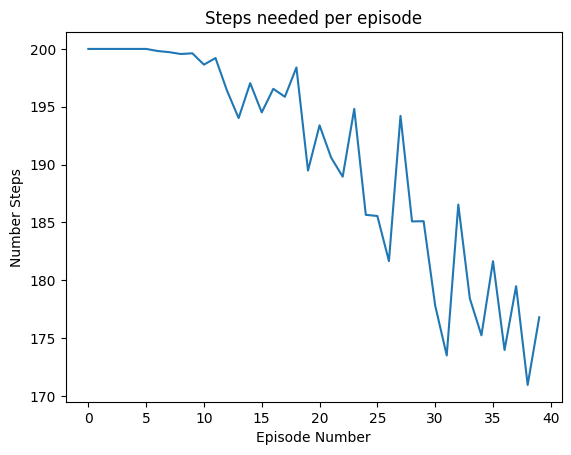

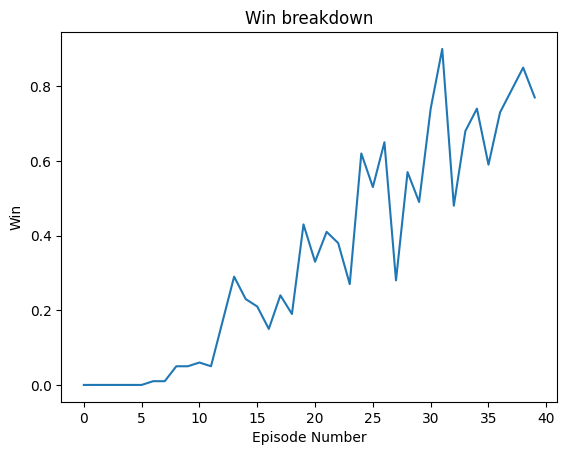

In [12]:
# Average results every N timesteps for better visualization.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps_sarsa = np.array(episode_steps_sarsa).reshape((episode_ticks, average_range))
avg_steps_sarsa = np.mean(avg_steps_sarsa, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Plot

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps_sarsa)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

In [13]:
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

observation,_ = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(Q_table[position][velocity])
    observation, reward, done, truncated, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


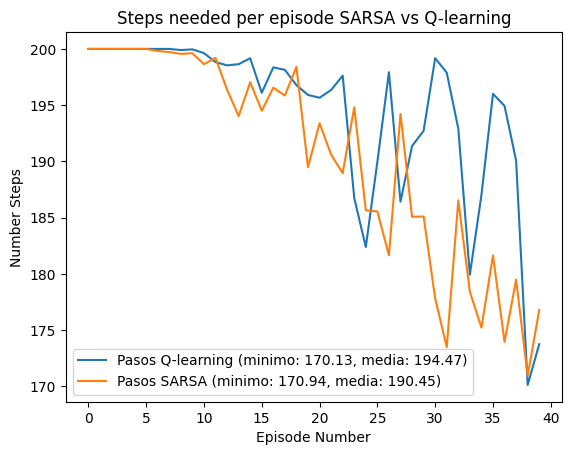

In [22]:
minimo_sarsa = min(avg_steps_sarsa)
minimo_q_learning = min(avg_steps)

media_sarsa = avg_steps_sarsa.mean()
media_q_learning = avg_steps.mean()
plt.plot(range(episode_ticks), avg_steps, label=f'Pasos Q-learning (minimo: {minimo_q_learning}, media: {media_q_learning:.2f})')
plt.plot(range(episode_ticks), avg_steps_sarsa, label=f'Pasos SARSA (minimo: {minimo_sarsa}, media: {media_sarsa:.2f})')
plt.title("Steps needed per episode SARSA vs Q-learning")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.legend()
plt.show()

Tal como se puede observar, no existe una diferencia muy significativa en cuanto al rendimiento medio en pasos de ambas técnicas. Si bien SARSA tiende a ser mas robusta, ambas llegan a un minimo de 170 pasos por episodio minimo. la diferencia promedio es de apenas 4, lo que no es una gran diferencia entre ambas tecnicas.